In [2]:
# Reference: https://github.com/KasperGroesLudvigsen/xgboost_time_series.git

In [25]:
import pandas as pd
import numpy as np
from typing import Tuple
#import utils
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

# Define hyperparameters and other important variables

In [5]:
target_variable = "S77"

timestamp_col = "timestamp"

target_sequence_length = 7

test_size = 0.20

first_day_test = "2022-12-18"

last_day_test = "2023-03-15"

hyperparameters = {
    "in_length" : 6,
    "step_size" : 1,
    "n_estimators" : 20,
    "max_depth" : 6,
    "subsample" : 0.5,
    "min_child_weight" : 1,
    "selected_features" : [target_variable]
    }

# Prepare data

First, we load the data and split it into train and test. It is important that the shuffle argument is False, because we need to maintain the original order of the data points in the data. 

In [6]:
%cd "C:\Users\Angel\Documents\NUS\Y3S2\DSA3101 Data Science in Practice\DSA3101\project_backend\rain_data_full"
%pwd

# Import full dataset
dataset = pd.read_csv('rain_data_2022-2023.csv', index_col=[0])

# number of days in total
dataset['date'].nunique()


C:\Users\Angel\Documents\NUS\Y3S2\DSA3101 Data Science in Practice\DSA3101\project_backend\rain_data_full


431

In [7]:
# select all data from 2022-2023
df = dataset.iloc[:, :2]
df = df.dropna()
df.reset_index(drop=True, inplace=True)
df

,timestamp,S77
0,2022-01-01T00:05:00+08:00,0.0
1,2022-01-01T00:10:00+08:00,0.0
2,2022-01-01T00:15:00+08:00,0.0
3,2022-01-01T00:20:00+08:00,0.0
4,2022-01-01T00:25:00+08:00,0.0
...,...,...
123148,2023-03-15T23:35:00+08:00,0.0
123149,2023-03-15T23:40:00+08:00,0.0
123150,2023-03-15T23:45:00+08:00,0.0
123151,2023-03-15T23:50:00+08:00,0.0


In [8]:
df['idx'] = df.index

timestamp_col = "timestamp"
# Convert HourDK to proper date time and make it index
df[timestamp_col] = pd.to_datetime(df[timestamp_col])
df.index = pd.to_datetime(df[timestamp_col])

In [9]:
df

,timestamp,S77,idx
timestamp,,,
2022-01-01 00:05:00+08:00,2022-01-01 00:05:00+08:00,0.0,0
2022-01-01 00:10:00+08:00,2022-01-01 00:10:00+08:00,0.0,1
2022-01-01 00:15:00+08:00,2022-01-01 00:15:00+08:00,0.0,2
2022-01-01 00:20:00+08:00,2022-01-01 00:20:00+08:00,0.0,3
2022-01-01 00:25:00+08:00,2022-01-01 00:25:00+08:00,0.0,4
...,...,...,...
2023-03-15 23:35:00+08:00,2023-03-15 23:35:00+08:00,0.0,123148
2023-03-15 23:40:00+08:00,2023-03-15 23:40:00+08:00,0.0,123149
2023-03-15 23:45:00+08:00,2023-03-15 23:45:00+08:00,0.0,123150


In [10]:
training_data = df[df.index < first_day_test]
training_data

,timestamp,S77,idx
timestamp,,,
2022-01-01 00:05:00+08:00,2022-01-01 00:05:00+08:00,0.0,0
2022-01-01 00:10:00+08:00,2022-01-01 00:10:00+08:00,0.0,1
2022-01-01 00:15:00+08:00,2022-01-01 00:15:00+08:00,0.0,2
2022-01-01 00:20:00+08:00,2022-01-01 00:20:00+08:00,0.0,3
2022-01-01 00:25:00+08:00,2022-01-01 00:25:00+08:00,0.0,4
...,...,...,...
2022-12-17 23:35:00+08:00,2022-12-17 23:35:00+08:00,0.0,100548
2022-12-17 23:40:00+08:00,2022-12-17 23:40:00+08:00,0.0,100549
2022-12-17 23:45:00+08:00,2022-12-17 23:45:00+08:00,0.0,100550


In [11]:
test_data = df[df.index >= first_day_test]
test_data = test_data[test_data.index <= last_day_test]
test_data

,timestamp,S77,idx
timestamp,,,
2022-12-18 00:05:00+08:00,2022-12-18 00:05:00+08:00,0.0,100553
2022-12-18 00:10:00+08:00,2022-12-18 00:10:00+08:00,0.0,100554
2022-12-18 00:15:00+08:00,2022-12-18 00:15:00+08:00,0.0,100555
2022-12-18 00:20:00+08:00,2022-12-18 00:20:00+08:00,0.0,100556
2022-12-18 00:25:00+08:00,2022-12-18 00:25:00+08:00,0.0,100557
...,...,...,...
2023-03-14 23:35:00+08:00,2023-03-14 23:35:00+08:00,0.0,122861
2023-03-14 23:40:00+08:00,2023-03-14 23:40:00+08:00,0.0,122862
2023-03-14 23:45:00+08:00,2023-03-14 23:45:00+08:00,0.0,122863


In [12]:
def get_indices_entire_sequence(
    data: pd.DataFrame, 
    window_size: int, 
    step_size: int
    ) -> list:
        """
        Produce all the start and end index positions that is needed to produce
        the sub-sequences. 
        Returns a list of tuples. Each tuple is (start_idx, end_idx) of a sub-
        sequence. These tuples should be used to slice the dataset into sub-
        sequences. These sub-sequences should then be passed into a function
        that slices them into input and target sequences. 
        
        Args:
            data (pd.DataFrame): Partitioned data set, e.g. training data

            window_size (int): The desired length of each sub-sequence. Should be
                               (input_sequence_length + target_sequence_length)
                               E.g. if you want the model to consider the past 100
                               time steps in order to predict the future 50 
                               time steps, window_size = 100+50 = 150
            step_size (int): Size of each step as the data sequence is traversed 
                             by the moving window.
                             If 1, the first sub-sequence will be [0:window_size], 
                             and the next will be [1:window_size].
        Return:
            indices: a list of tuples
        """

        stop_position = len(data)-1 # 1- because of 0 indexing
        
        # Start the first sub-sequence at index position 0
        subseq_first_idx = 0
        
        subseq_last_idx = window_size
        
        indices = []
        
        while subseq_last_idx <= stop_position:

            indices.append((subseq_first_idx, subseq_last_idx))
            
            subseq_first_idx += step_size
            
            subseq_last_idx += step_size

        return indices

In [13]:
def get_xgboost_x_y(
    indices: list, 
    data: np.array,
    target_sequence_length,
    input_seq_len: int
    ) -> Tuple[np.array, np.array]:

    """
    Args:

        indices: List of index positions at which data should be sliced

        data: A univariate time series

        target_sequence_length: The forecasting horizon, m

        input_seq_len: The length of the model input, n

    Output: 

        all_x: np.array of shape (number of instances, input seq len)

        all_y: np.array of shape (number of instances, target seq len)

    """
    print("Preparing data..")

    # Loop over list of training indices
    for i, idx in enumerate(indices):

        # Slice data into instance of length input length + target length
        data_instance = data[idx[0]:idx[1]]

        x = data_instance[0:input_seq_len]

        assert len(x) == input_seq_len

        y = data_instance[input_seq_len:input_seq_len+target_sequence_length]

        # Create all_y and all_x objects in first loop iteration
        if i == 0:

            all_y = y.reshape(1, -1)

            all_x = x.reshape(1, -1)

        else:

            all_y = np.concatenate((all_y, y.reshape(1, -1)), axis=0)

            all_x = np.concatenate((all_x, x.reshape(1, -1)), axis=0)

    print("Finished preparing data!")

    return all_x, all_y

In [14]:
# Create indices. Must be passed to function that creates (X,Y) pairs so that
# it knows where to slice the data
training_indices = get_indices_entire_sequence(
    data=training_data, 
    window_size=hyperparameters["in_length"]+target_sequence_length, 
    step_size=hyperparameters["step_size"]
    )

# Obtain (X,Y) pairs of training data
x_train, y_train = get_xgboost_x_y(
    indices=training_indices, 
    data=training_data[hyperparameters["selected_features"]].to_numpy(),
    target_sequence_length=target_sequence_length,
    input_seq_len=hyperparameters["in_length"]
    )

test_indices = get_indices_entire_sequence(
    data=test_data, 
    window_size=hyperparameters["in_length"]+target_sequence_length, 
    step_size=1
    )

# Obtain (X,Y) pairs of test data
x_test, y_test = get_xgboost_x_y(
    indices=test_indices, 
    data=test_data[hyperparameters["selected_features"]].to_numpy(),
    target_sequence_length=target_sequence_length,
    input_seq_len=hyperparameters["in_length"]
    )

# ~2min 15s

Preparing data..
Finished preparing data!
Preparing data..
Finished preparing data!


# Train model

In [15]:
np.argwhere(np.isnan(y_train))
np.argwhere(np.isnan(y_test))

array([], shape=(0, 2), dtype=int64)

In [16]:
# Initialize model
model = xgb.XGBRegressor(
    n_estimators=hyperparameters["n_estimators"],
    max_depth=hyperparameters["max_depth"],
    subsample=hyperparameters["subsample"],
    min_child_weight=hyperparameters["min_child_weight"],
    objective="reg:squarederror",
    tree_method="hist",
    random_state=3101
    )

trained_model = MultiOutputRegressor(model).fit(x_train, y_train)

train_forecasts = trained_model.predict(x_train)

# Test model

In [17]:
test_forecasts = trained_model.predict(x_test)

In [22]:
# extract only the rainfall value predicted for t= +30min from entire window of 7 steps
test_forecasts_solo = []
test_forecasts_classed = []

for ys in test_forecasts:
    y = ys[-1]
    test_forecasts_solo.append(y)
    test_forecasts_classed.append(1) if y >= 0.25 else test_forecasts_classed.append(0)

test_forecasts_solo = np.array(test_forecasts_solo)
test_forecasts_classed = np.array(test_forecasts_classed)


y_test_solo = []
y_test_classed = []

for ys in y_test:
    y = ys[-1]
    y_test_solo.append(y)
    y_test_classed.append(1) if y > 0.25 else y_test_classed.append(0)

y_test_solo = np.array(y_test_solo)
y_test_classed = np.array(y_test_classed)

In [23]:
result = pd.DataFrame({'actual':y_test_solo, 'predicted':test_forecasts_solo})
result

,actual,predicted
0,0.0,0.016226
1,0.0,0.016226
2,0.0,0.016226
3,0.0,0.016226
4,0.0,0.016226
...,...,...
22295,0.0,0.016226
22296,0.0,0.016226
22297,0.0,0.016226
22298,0.0,0.016226


In [26]:
# Metric: MSE
test_mse = mean_squared_error(y_test_solo, test_forecasts_solo)

# Metric: MAE
test_mae = mean_absolute_error(y_test_solo, test_forecasts_solo)

threshold = 0.0
# Metric: FN rate --> Worst Case: Predicted no rain, but rained
fn = result[result['actual'] > threshold]  ## all actual positives
fn = fn[round(fn['predicted'], 1) <= threshold]
test_fnr = len(fn) / len(result[result['actual'] > threshold])

# Metric: FP rate --> 2nd Worst Case: Predicted rain, but no rain
fp = result[result['actual'] <= threshold]  ## all actual negatives
fp = fp[round(fp['predicted'], 1) > threshold]
test_fpr = len(fp) / len(result[result['actual'] <= threshold])

# Metric: R-squared score
test_r_squared = r2_score(y_test_solo, test_forecasts_solo)

In [27]:
# Metrics output
print("MSE is: {}".format(test_mse))
print("MAE is: {}".format(test_mae))
print("FN Rate is: {}".format(test_fnr))
print("FP Rate is: {}".format(test_fpr))
print("R-squared Score is: {}".format(test_r_squared))

MSE is: 0.0948122278810343
MAE is: 0.055385791468170936
FN Rate is: 0.3600713012477718
FP Rate is: 0.05307394465955237
R-squared Score is: 0.04841086841985298


# Plot forecasts against targets/actual values

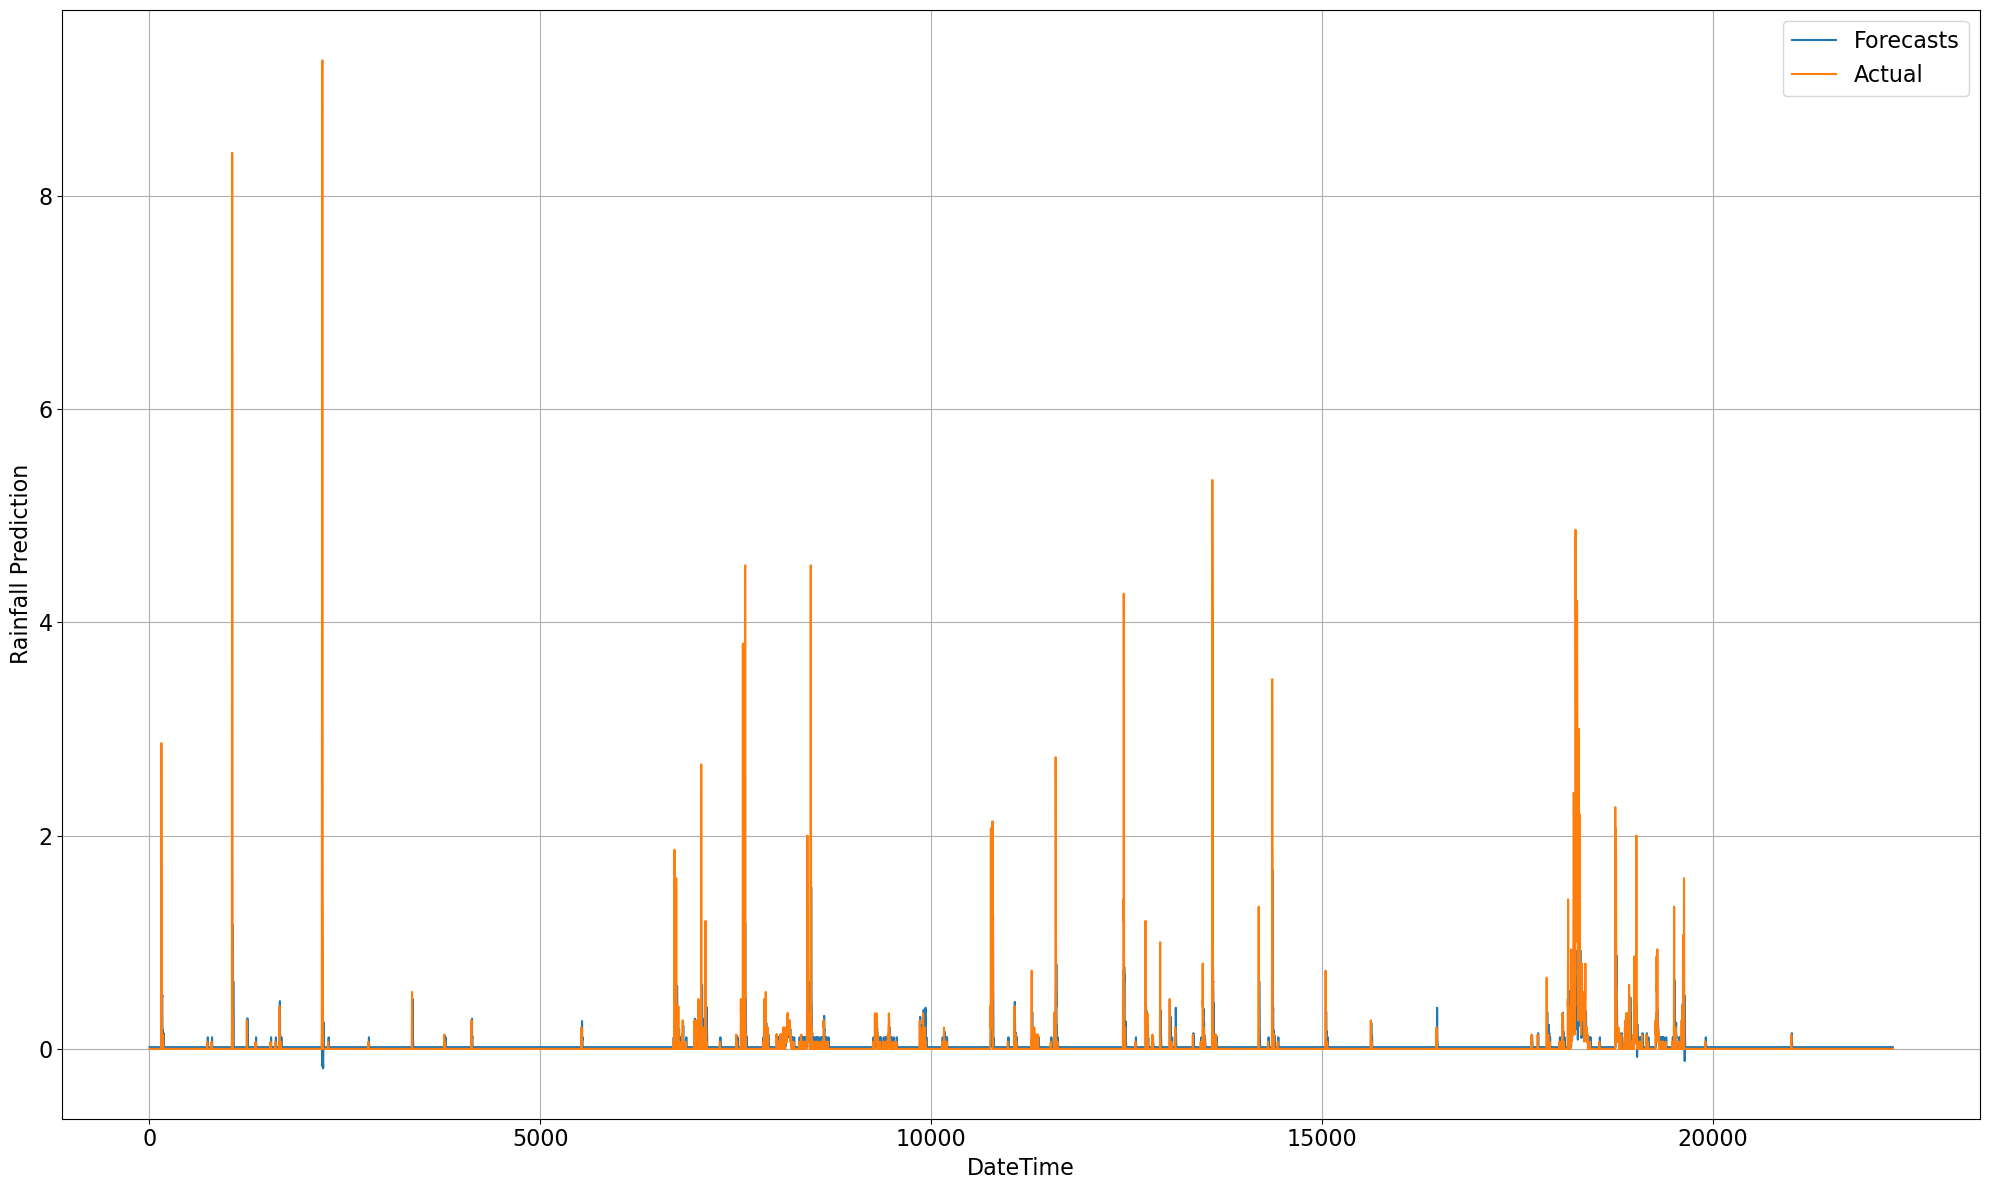

In [28]:
fontsize = 16
plot_df = pd.DataFrame({"Forecasts" : test_forecasts_solo.flatten(), "Actual" : y_test_solo.flatten()}, index=range(len(y_test_solo.flatten())))

fig = plt.figure(figsize=(20,12))
plt.plot(plot_df.index, plot_df["Forecasts"].rolling(3).mean(), label="Forecasts")
plt.plot(plot_df.index, plot_df["Actual"].rolling(3).mean(), label="Actual")

plt.xlabel('DateTime', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.ylabel("Rainfall Prediction", fontsize=fontsize)
plt.grid(True)
plt.legend(fontsize=fontsize)
plt.tight_layout()